# Торговый бот
- Тренировка: фьючерсы сбера (SBRF), шаг - 1 час
- Тест: см. ниже

In [1]:
import tensorflow as tf
import numpy as np
from finta import TA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, normalize
import sys
import pylab
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [129]:
WINDOW_SIZE = 40
TRAIN_TEST_SPLIT = 0.97 # set to 0.1 for other stocks data testing

In [130]:
def preprocess(fname):
    df = pd.read_csv(fname)
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    
    dft = df['<CLOSE>'] - df['<CLOSE>'].shift()
    dft.fillna(0, inplace=True)
    dft = dft.values
    signals = np.array([1 if i > 0 else 0 for i in dft])[WINDOW_SIZE:]
    
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    dfcopy = df.copy()
    indicators = pd.DataFrame()
    indicators['KAMA'] = TA.KAMA(df)
    indicators['TEMA'] = TA.TEMA(df)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    indicators['AO'] = TA.AO(df)
    indicators['RSI'] = TA.RSI(df)
    indicators = indicators.assign(**TA.EV_MACD(df))
    indicators = minmax_scale(indicators[WINDOW_SIZE:].values, axis=0)
    
    dfcopy = dfcopy.close[WINDOW_SIZE:].values
    dfcopy = np.array([dfcopy[i+WINDOW_SIZE] for i in range(len(signals)-WINDOW_SIZE)])
    data = np.array([indicators[i:i+WINDOW_SIZE] for i in range(len(indicators)-WINDOW_SIZE)])
    signals = np.array([signals[i+WINDOW_SIZE] for i in range(len(signals)-WINDOW_SIZE)])
    
    split_index = int(len(data)*TRAIN_TEST_SPLIT)
    data_train, signals_train = data[:split_index], signals[:split_index]
    data_test, signals_test, dfcopy = data[split_index:], signals[split_index:], dfcopy[split_index:]
    return data_train, signals_train, data_test, signals_test, dfcopy

data_train, signals_train, data_test, signals_test, dfcopy = preprocess('AFLTH.csv')

In [127]:
model = Sequential()
#model.add(Dropout(0.1, input_shape=(WINDOW_SIZE, 7)))
model.add(Reshape((WINDOW_SIZE, 7, 1), input_shape=(WINDOW_SIZE, 7)))
filters = 24
model.add(Conv2D(filters, (1, 7), padding='valid'))
model.add(ReLU())
model.add(Dropout(0.25))
model.add(Reshape((WINDOW_SIZE, filters)))
model.add(Conv1D(32, kernel_size=3))
model.add(ReLU())
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Conv1D(32, kernel_size=3))
model.add(ReLU())
model.add(MaxPooling1D())
model.add(Dropout(0.25))
model.add(Conv1D(32, kernel_size=3))
model.add(ReLU())
model.add(MaxPooling1D())
model.add(BatchNormalization())
model.add(CuDNNLSTM(4, return_sequences=True))
model.add(CuDNNLSTM(4))
model.add(BatchNormalization())
model.add(Dense(1, activation='sigmoid'))

model.summary()
model.compile(optimizer=Adam(0.001, epsilon=1e-7), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 40, 7, 1)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 1, 24)         192       
_________________________________________________________________
re_lu_12 (ReLU)              (None, 40, 1, 24)         0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 40, 1, 24)         0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 40, 24)            0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 38, 32)            2336      
_________________________________________________________________
re_lu_13 (ReLU)              (None, 38, 32)           

In [6]:
model = tf.keras.models.load_model('workingfull.h5')

W0331 02:17:31.959883  2320 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0331 02:17:31.968135  2320 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0331 02:17:31.971402  2320 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) wit

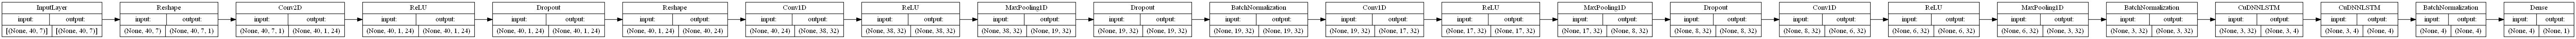

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

In [147]:
model.fit(data_train, signals_train, shuffle=False, epochs=500, validation_data=(data_test, signals_test))

Train on 32568 samples, validate on 1008 samples
Epoch 1/500
32568/32568 [==============================] - 29s 876us/sample - loss: 0.6795 - acc: 0.5656 - val_loss: 0.7133 - val_acc: 0.4871
Epoch 2/500
32568/32568 [==============================] - 28s 852us/sample - loss: 0.6799 - acc: 0.5651 - val_loss: 0.7167 - val_acc: 0.4831
Epoch 3/500
32568/32568 [==============================] - 28s 858us/sample - loss: 0.6790 - acc: 0.5646 - val_loss: 0.7131 - val_acc: 0.4802
Epoch 4/500
32568/32568 [==============================] - 27s 832us/sample - loss: 0.6789 - acc: 0.5678 - val_loss: 0.7137 - val_acc: 0.4931
Epoch 5/500
32568/32568 [==============================] - 28s 851us/sample - loss: 0.6800 - acc: 0.5629 - val_loss: 0.7088 - val_acc: 0.4752
Epoch 6/500
32568/32568 [==============================] - 29s 887us/sample - loss: 0.6798 - acc: 0.5658 - val_loss: 0.7096 - val_acc: 0.4871
Epoch 7/500
32568/32568 [==============================] - 31s 938us/sample - loss: 0.6796 - acc: 0

KeyboardInterrupt: 

In [148]:
model.save_weights('workingafltweights.h5')
tf.keras.models.save_model(model, 'workingafltmodel.h5')

In [193]:
SURE = 0.05
COMISSION = 0.01/100
BROKER_COMISSION = 10

def model_test(fname, data_test, dfcopy):
    sure = SURE
    money = 100000
    cur_stocks = 0

    sells = []
    buys = []
    stats = []

    preds = model.predict(data_test)
    temp_df = dfcopy.copy()
    #temp_df = temp_df[int(len(dfcopy)*TRAIN_TEST_SPLIT):].values
    for i, p in enumerate(preds):
        price = temp_df[i]
        if abs(p - 0.5) > sure:
            if p <= 0.5:
                if cur_stocks > 0:
                    sells.append(i)
                    money -= BROKER_COMISSION
                #n_stocks = money // price
                money += cur_stocks*price*(1-COMISSION)
                cur_stocks = 0
            else:
                n_stocks = money // price
                if n_stocks > 0:
                    buys.append(i)
                    money -= BROKER_COMISSION
                money -= n_stocks*price*(1+COMISSION)
                cur_stocks += n_stocks
        stats.append(price*cur_stocks + money)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(fname, fontsize=20)
    axes[0].set_title("Зависимость стоимости акций (цена закрытия) от времени")
    axes[0].plot(temp_df)
    axes[0].plot(temp_df, '^', markersize=10, color='m', label = 'buying signal', markevery = buys, alpha=0.5)
    axes[0].plot(temp_df, 'v', markersize=10, color='k', label = 'selling signal', markevery = sells, alpha=0.5)
    #axes[0].plot(temp_df, '.', markersize=1, color='m', label = 'buying signal', markevery = buys, alpha=1)
    #axes[0].plot(temp_df, '.', markersize=1, color='k', label = 'selling signal', markevery = sells, alpha=1)
    axes[0].legend()
    axes[0].set_xlabel("Время")
    axes[0].set_ylabel("Цена закрытия")
    axes[0].grid()
    
    axes[1].set_title("Зависимость количества средств от времени")
    axes[1].plot(stats)
    axes[1].set_xlabel("Время")
    axes[1].set_ylabel("Всего средств")
    axes[1].grid()

    fig.tight_layout(pad=3)

In [91]:
def automated_test(fname, title):
    data_train, signals_train, data_test, signals_test, dfcopy = preprocess(fname)
    model_test(title, data_test, dfcopy)

# Тестирование
Спойлер: заработок есть, но везде - уход в минус из-за недавнего падения стоимости акций: нейросеть не смогла предсказать такое резкое падение. А должна ли она уметь предсказывать такое? Как?..
## Сеть, тренированная на 1Н SBRF данных

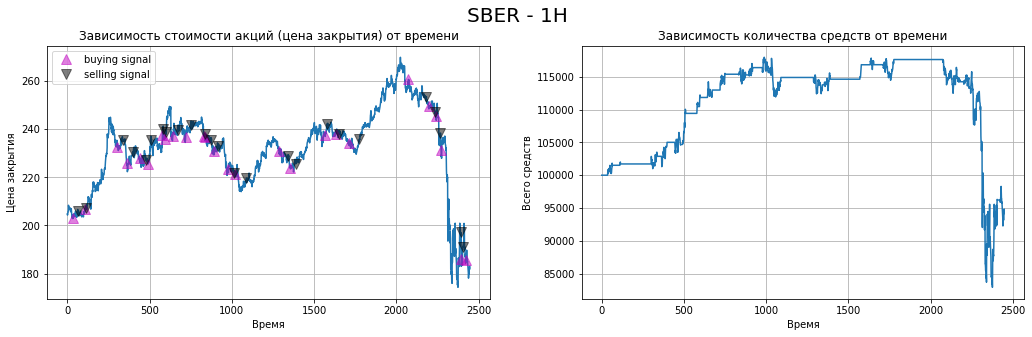

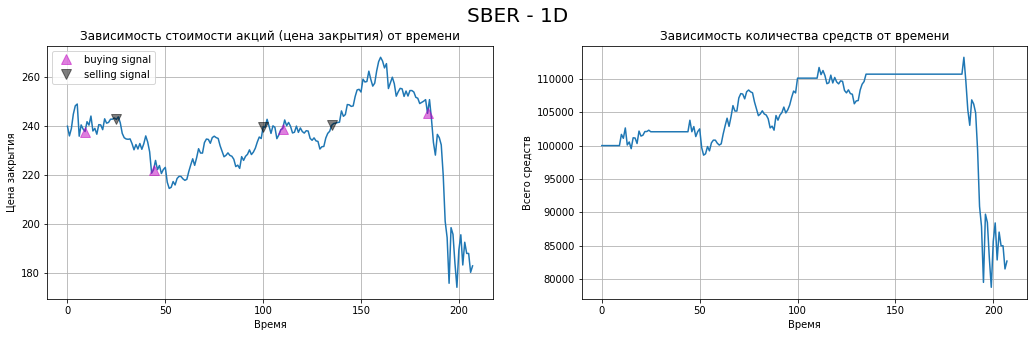

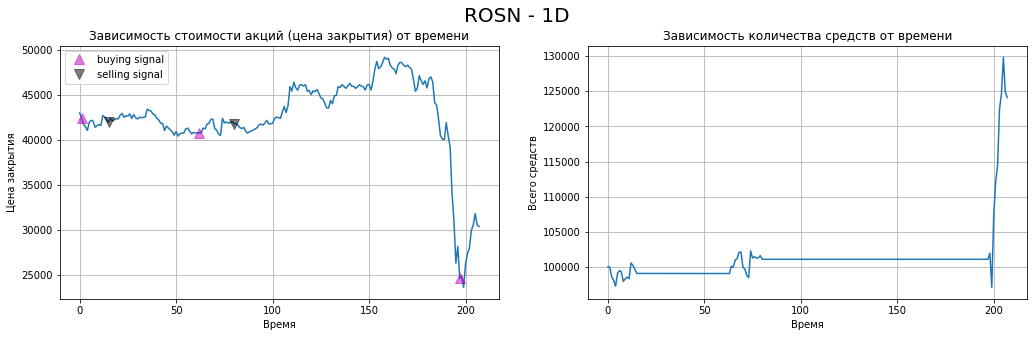

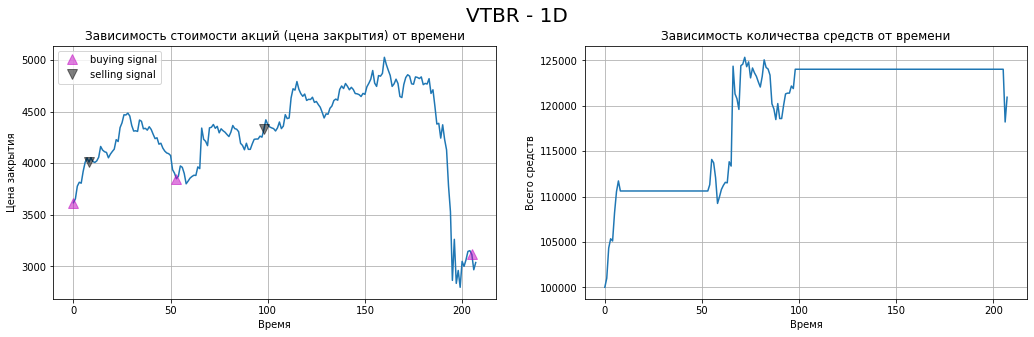

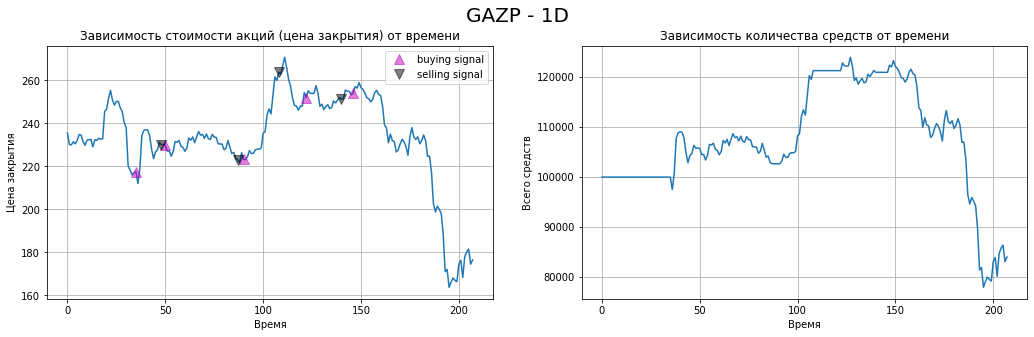

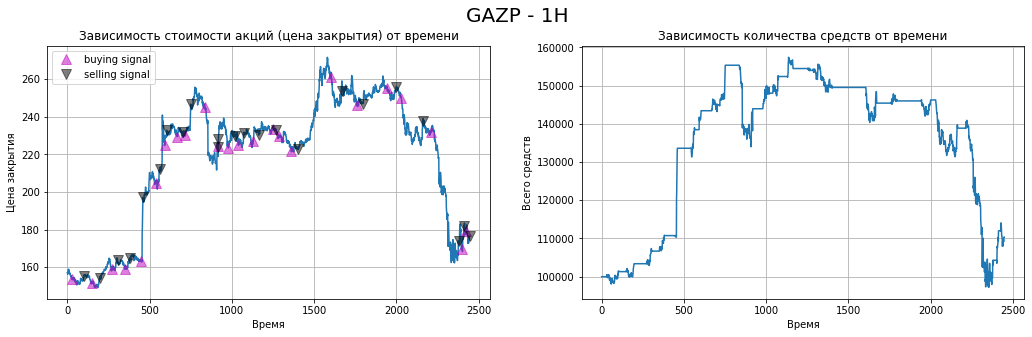

In [96]:
params = [('SBERH.csv', 'SBER - 1H'),
          ('SBERD.csv', 'SBER - 1D'),
          ('ROSN.csv', 'ROSN - 1D'),
          ('VTBR.csv', 'VTBR - 1D'),
          ('GAZPD.csv', 'GAZP - 1D'),
          ('GAZPH.csv', 'GAZP - 1H'),
         ]

for p in params:
    automated_test(*p)

## 1D AFLT + huge 1H AFLT

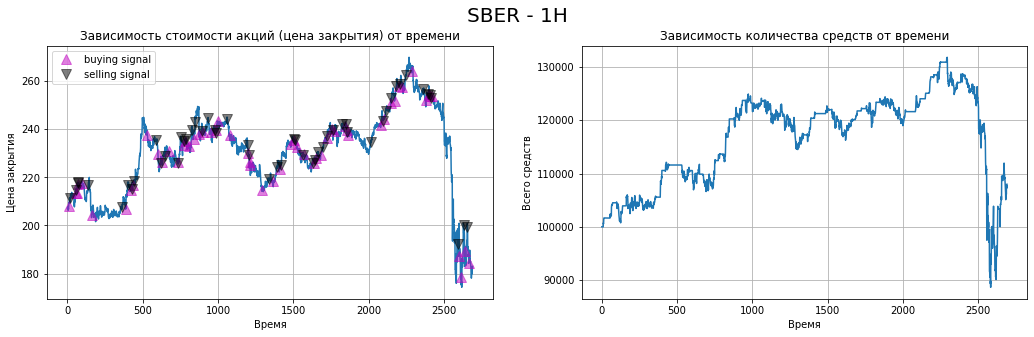

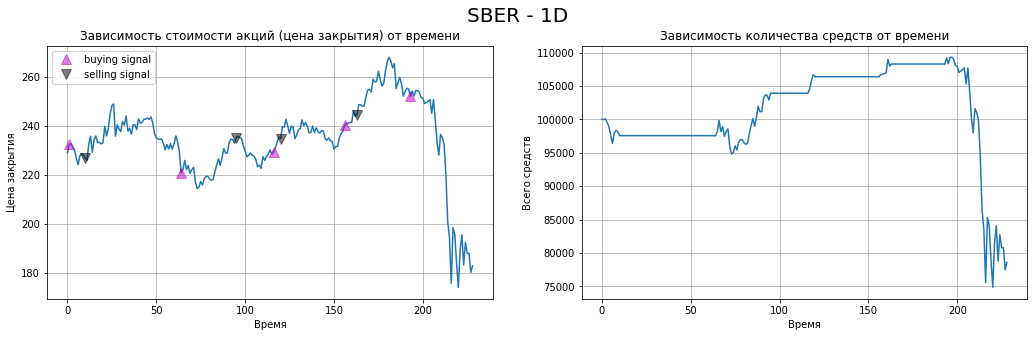

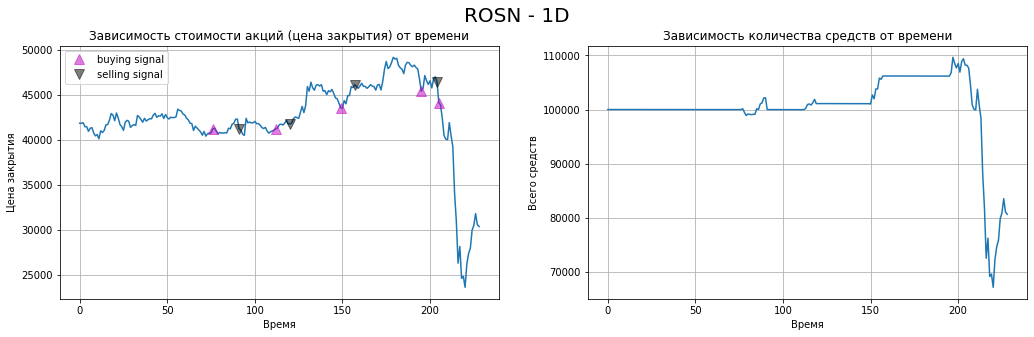

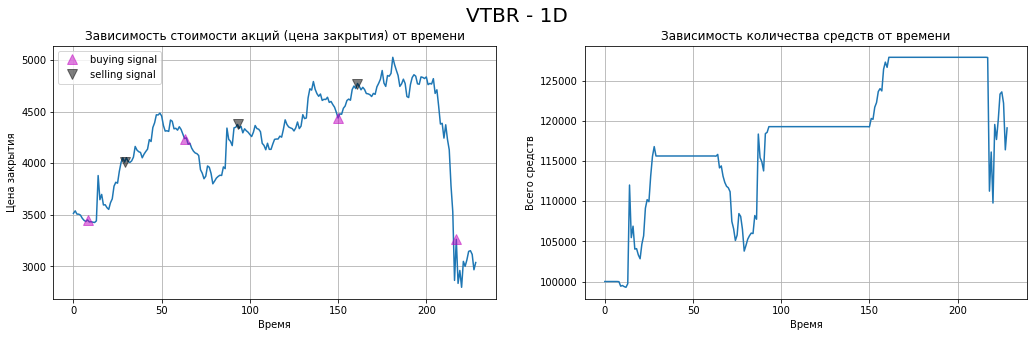

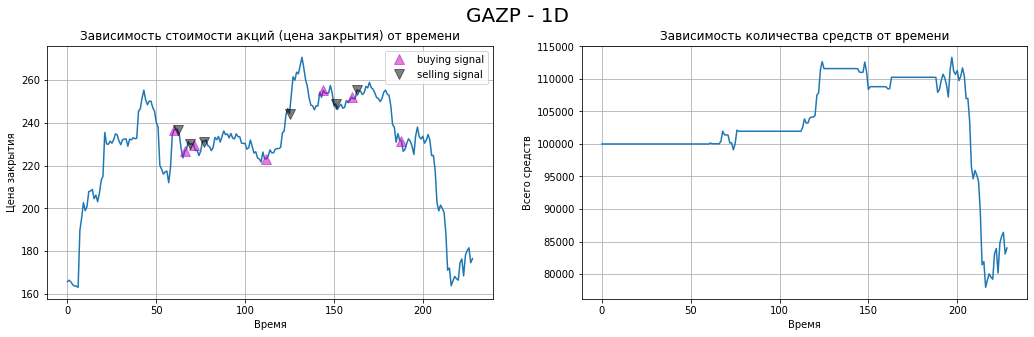

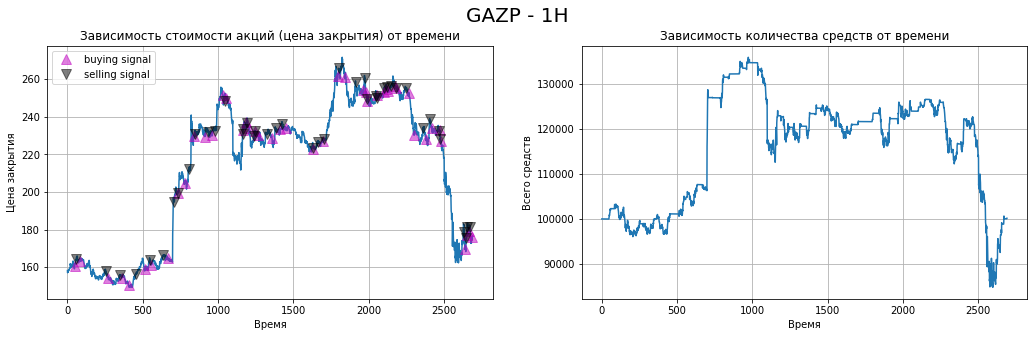

In [194]:
TRAIN_TEST_SPLIT = 0.01
params = [('SBERH.csv', 'SBER - 1H'),
          ('SBERD.csv', 'SBER - 1D'),
          ('ROSN.csv', 'ROSN - 1D'),
          ('VTBR.csv', 'VTBR - 1D'),
          ('GAZPD.csv', 'GAZP - 1D'),
          ('GAZPH.csv', 'GAZP - 1H'),
         ]

for p in params:
    automated_test(*p)
TRAIN_TEST_SPLIT = 0.97

### А можно ли заработать, если общий тренд - падение? Да:

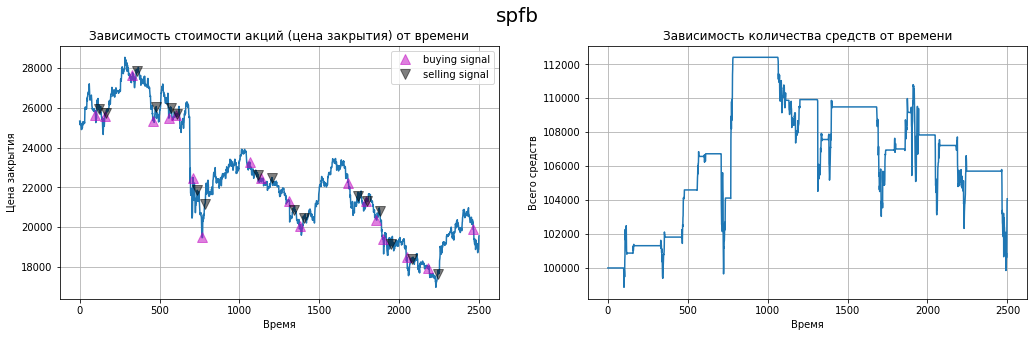

In [195]:
SURE = 0.1
TRAIN_TEST_SPLIT = 0.01
#df = pd.read_csv('SPFB2.csv')

data_train, signals_train, data_test, signals_test, dfcopy = preprocess('SPFB2.csv')
model_test('spfb', data_test[10500:13000], dfcopy[10500:13000])
TRAIN_TEST_SPLIT = 0.97

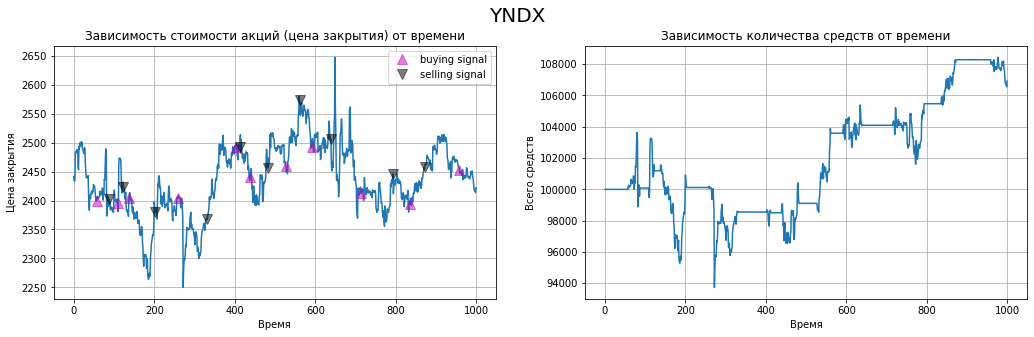

In [196]:
TRAIN_TEST_SPLIT = 0.01
#df = pd.read_csv('SPFB2.csv')

data_train, signals_train, data_test, signals_test, dfcopy = preprocess('YNDX.csv')
model_test('YNDX', data_test[9500:10500], dfcopy[9500:10500])
TRAIN_TEST_SPLIT = 0.97

# Выводы:
Похоже, у многих акций есть схожие паттерны, которые нейросеть успешно выучила. Доходность за год - несколько больше чем от банковского вклада. Но стоят ли риски того?